Question 1/ Newman Exercise 8.18

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def brusselator(t, y, a=1.0, b=3.0):
    x, ychem = y
    dx = 1.0 - (b + 1.0) * x + a * x * x * ychem
    dy = b * x - a * x * x * ychem
    return np.array([dx, dy], dtype=float)

def modified_midpoint(f, t0, y0, H, n):
    h = H / n
    f0 = f(t0, y0)
    z0 = y0
    z1 = y0 + h * f0
    for m in range(2, n + 1):
        tm = t0 + (m - 1) * h
        fm = f(tm, z1)
        z2 = z0 + 2.0 * h * fm
        z0, z1 = z1, z2

    fend = f(t0 + H, z1)
    y_end = 0.5 * (z1 + z0 + h * fend)
    return y_end, True

In [12]:
def bs_trial(f, t0, y0, H, delta_per_unit=1e-10, nmax=8):
    n_list = [2, 4, 6, 8]
    n_list = [n for n in n_list if n <= nmax]
    tol = delta_per_unit * abs(H)

    T = []
    for k, n in enumerate(n_list):
        y_mm, ok = modified_midpoint(f, t0, y0, H, n)
        if not ok:
            return False, y0, np.inf, n
        T.append([y_mm])

        for j in range(1, k + 1): 
            nk  = n_list[k]
            nkj = n_list[k - j]
            r = (nk / nkj) ** 2.0
            T_kj_1  = T[k][j - 1]
            T_km1_j = T[k - 1][j - 1]
            T[k].append(T_kj_1 + (T_kj_1 - T_km1_j) / (r - 1.0))

        y_best = T[k][-1]

        if k == 0:
            err = np.linalg.norm(T[k][0] - y0, ord=np.inf)
        else:
            err = np.linalg.norm(T[k][-1] - T[k - 1][-1], ord=np.inf)

        if np.isfinite(err) and err <= tol:
            return True, y_best, err, n
    return False, y0, err, n_list[-1]


In [13]:
def integrate_bs(f, t0, y0, t1, H0=20.0, delta_per_unit=1e-10, nmax=8, max_halves=40):
    t_arr = [float(t0)]
    y_arr = [np.array(y0, dtype=float)]
    boundaries = [float(t0)]

    t = float(t0)
    y = np.array(y0, dtype=float)
    H = float(H0)
    tiny = np.finfo(float).tiny * 100

    while t < t1 - 1e-14: 
        H = min(H, t1 - t)

        ok, y1, err, n_used = bs_trial(f, t, y, H, delta_per_unit=delta_per_unit, nmax=nmax)
        halves = 0
        while not ok:
            H *= 0.5
            halves += 1
            if halves > max_halves or H < tiny:
                raise RuntimeError("Cannot satisfy tolerance.")
            ok, y1, err, n_used = bs_trial(f, t, y, H, delta_per_unit=delta_per_unit, nmax=nmax)

        # accept
        t += H
        y = y1
        t_arr.append(t)
        y_arr.append(y.copy())
        boundaries.append(t)
    return np.array(t_arr), np.vstack(y_arr), np.array(boundaries)


/var/folders/hf/mzwybxv54rqfdvn46vtf4l7m0000gn/T/ipykernel_24481/1948895716.py:3: RuntimeWarning: overflow encountered in double_scalars
  dx = 1.0 - (b + 1.0) * x + a * x * x * ychem
/var/folders/hf/mzwybxv54rqfdvn46vtf4l7m0000gn/T/ipykernel_24481/1948895716.py:4: RuntimeWarning: overflow encountered in double_scalars
  dy = b * x - a * x * x * ychem
/var/folders/hf/mzwybxv54rqfdvn46vtf4l7m0000gn/T/ipykernel_24481/1948895716.py:23: RuntimeWarning: invalid value encountered in add
  y_end = 0.5 * (z1 + z0 + h * fend)


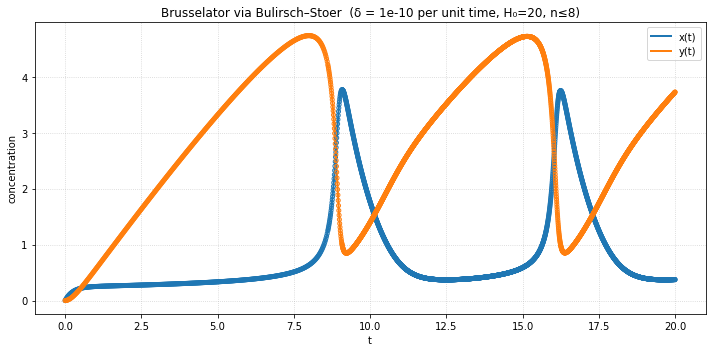

In [14]:
def main():
    a, b = 1.0, 3.0
    t0, t1 = 0.0, 20.0
    y0 = np.array([0.0, 0.0])
    H0 = 20.0               
    delta = 1e-10            
    nmax = 8                

    f = lambda t, y: brusselator(t, y, a=a, b=b)

    t_arr, y_arr, bounds = integrate_bs(f, t0, y0, t1, H0=H0, delta_per_unit=delta, nmax=nmax)
    x = y_arr[:, 0]
    ychem = y_arr[:, 1]

    plt.figure(figsize=(10, 5))
    plt.plot(t_arr, x, color="#1f77b4", lw=2.0, label="x(t)")
    plt.plot(t_arr, ychem, color="#ff7f0e", lw=2.0, label="y(t)")

    plt.scatter(bounds, np.interp(bounds, t_arr, x),
                s=16, facecolors="none", edgecolors="#1f77b4", zorder=3)
    plt.scatter(bounds, np.interp(bounds, t_arr, ychem),
                s=16, facecolors="none", edgecolors="#ff7f0e", zorder=3)

    plt.xlabel("t")
    plt.ylabel("concentration")
    plt.title("Brusselator via Bulirsch–Stoer  (δ = 1e-10 per unit time, H₀=20, n≤8)")
    plt.grid(True, ls=":", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()
if __name__ == "__main__":
    main()
